In [351]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
import math 
from arch import arch_model
from arch.univariate import GARCH
import tensorflow_probability as tfp
import seaborn as sns
import tensorflow.math as m
pi = tf.constant(math.pi)
from sklearn.metrics import mean_squared_error as mse


mpl.rcParams['figure.figsize'] = (18,8)

In [37]:
def nll(sigma, x):
    x = tf.reshape(x, (x.shape[0]))
    tfd = tfp.distributions
    dist = tfd.Normal(loc=0., scale=sigma)
    return -1*tf.math.reduce_sum(tf.math.log(dist.prob(x)))

In [406]:
class RNN(keras.Model):
    def __init__(self,
                 hiddens = [100, 1],
                 activation = 'relu',
                 optimizer= 'adam',
                 last_activation = 'relu',
                 drop_rate = .6
                ):
        super().__init__()
        self.optimizer = optimizer
        self.drop_rate = drop_rate
        self.dropout = Dropout(self.drop_rate)
        self.activation = activation; self.last_activation = last_activation
        self.hiddens = hiddens
        self.initializer =  tf.keras.initializers.RandomNormal(mean=0.0, stddev=30)
        self.rnn = SimpleRNN(self.hiddens[0],
                             activation = self.activation,
                             kernel_initializer = self.initializer                         
                            )
        self.denses = []
        for size in self.hiddens[1:-1]:
            self.denses.append(Dense(size, activation = self.activation))
        self.denses.append(Dense(self.hiddens[-1], activation = self.last_activation))
        
    def call(self, x):
        out = self.rnn(x)
        for l in self.denses:
            out = l(out)
            out = self.dropout(out)
            return out
    
    def train(self,
              x,
              epochs = 10,
              loss_fn = nll,
              use_rv = False,
              scale = 1
             ):
        #see if batched data is needed
#         x[:,0,:] = x[:,0,:]*scale
        print(30*'*'+'\nFITING THE MODEL\n'+30*'*')
        self.loss_to_plot = []
        self.compile(optimizer = self.optimizer, loss = loss_fn)
        for epoch in tqdm(range(epochs)):
            with tf.GradientTape() as tape:
                logits = self(x)**.5
                loss = loss_fn(logits, x[:,0,:])
            print(30*'-')
            print('EPOCH:{}'.format(epoch+1))
            print('NLL:{}'.format(loss))
            gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
            self.loss_to_plot.append(loss.numpy())
    
    def plot_loss(self):
        plt.plot(self.loss_to_plot)

In [445]:
stock = yf.Ticker('^GSPC').history(start = '2010-01-01', end = '2022-03-01').Close
rets_ = stock.pct_change().dropna()
rets = rets_-rets_.mean()
tf_rets = tf.convert_to_tensor(rets.values,  dtype='float32')[21:]
tf_rv = tf.convert_to_tensor(rets.rolling(22).std().dropna().values, dtype = 'float32')
#data = tf.stack((tf_rets, tf_rv), axis= 1)
data = tf.reshape(tf_rets, (tf_rets.shape[0],1, 1))
# tf_rets = tf.reshape(tf_rets, (tf_rets.shape[0],1,1))

In [446]:
model = RNN(hiddens = [100,1], activation='tanh', last_activation = 'sigmoid', drop_rate = 0)
model(data)
model.summary()
model.train(data, epochs = 300, use_rv = False, loss_fn = nll2)

Model: "rnn_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_23 (Dropout)        multiple                  0         
                                                                 
 simple_rnn_84 (SimpleRNN)   multiple                  10200     
                                                                 
 dense_107 (Dense)           multiple                  101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________
******************************
FITING THE MODEL
******************************


  0%|          | 0/300 [00:00<?, ?it/s]

------------------------------
EPOCH:1
NLL:1739.3590087890625
------------------------------
EPOCH:2
NLL:1729.2152099609375
------------------------------
EPOCH:3
NLL:1718.880859375
------------------------------
EPOCH:4
NLL:1708.34375
------------------------------
EPOCH:5
NLL:1697.5926513671875
------------------------------
EPOCH:6
NLL:1686.6163330078125
------------------------------
EPOCH:7
NLL:1675.4073486328125
------------------------------
EPOCH:8
NLL:1663.9581298828125
------------------------------
EPOCH:9
NLL:1652.2603759765625
------------------------------
EPOCH:10
NLL:1640.3072509765625
------------------------------
EPOCH:11
NLL:1628.0916748046875
------------------------------
EPOCH:12
NLL:1615.6063232421875
------------------------------
EPOCH:13
NLL:1602.8438720703125
------------------------------
EPOCH:14
NLL:1589.798095703125
------------------------------
EPOCH:15
NLL:1576.4632568359375
------------------------------
EPOCH:16
NLL:1562.832275390625
---------------

------------------------------
EPOCH:136
NLL:-3572.754638671875
------------------------------
EPOCH:137
NLL:-3654.257568359375
------------------------------
EPOCH:138
NLL:-3736.264892578125
------------------------------
EPOCH:139
NLL:-3818.752685546875
------------------------------
EPOCH:140
NLL:-3901.700927734375
------------------------------
EPOCH:141
NLL:-3985.100830078125
------------------------------
EPOCH:142
NLL:-4068.924072265625
------------------------------
EPOCH:143
NLL:-4153.1533203125
------------------------------
EPOCH:144
NLL:-4237.7587890625
------------------------------
EPOCH:145
NLL:-4322.75
------------------------------
EPOCH:146
NLL:-4408.0908203125
------------------------------
EPOCH:147
NLL:-4493.75
------------------------------
EPOCH:148
NLL:-4579.7412109375
------------------------------
EPOCH:149
NLL:-4666.0087890625
------------------------------
EPOCH:150
NLL:-4752.5537109375
------------------------------
EPOCH:151
NLL:-4839.3466796875
----------

EPOCH:271
NLL:-10955.9169921875
------------------------------
EPOCH:272
NLL:-10957.0791015625
------------------------------
EPOCH:273
NLL:-10958.232421875
------------------------------
EPOCH:274
NLL:-10959.376953125
------------------------------
EPOCH:275
NLL:-10960.50390625
------------------------------
EPOCH:276
NLL:-10961.6181640625
------------------------------
EPOCH:277
NLL:-10962.7080078125
------------------------------
EPOCH:278
NLL:-10963.7685546875
------------------------------
EPOCH:279
NLL:-10964.80078125
------------------------------
EPOCH:280
NLL:-10965.810546875
------------------------------
EPOCH:281
NLL:-10966.794921875
------------------------------
EPOCH:282
NLL:-10967.7509765625
------------------------------
EPOCH:283
NLL:-10968.6865234375
------------------------------
EPOCH:284
NLL:-10969.59765625
------------------------------
EPOCH:285
NLL:-10970.48828125
------------------------------
EPOCH:286
NLL:-10971.3740234375
------------------------------
EPOC

C:\Users\Giorgio\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Giorgio\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Giorgio\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

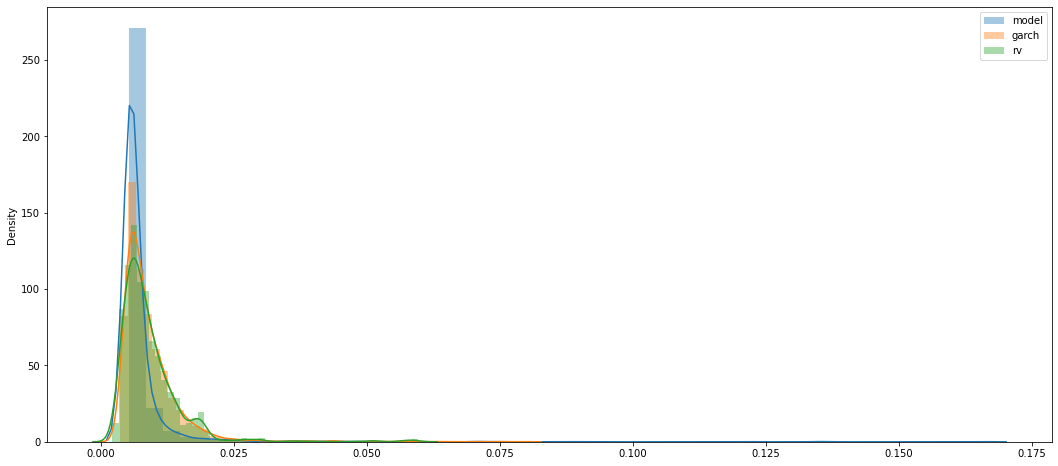

In [447]:
sns.distplot((model(data)**.5).numpy().ravel(), label = 'model')
sns.distplot(fit.conditional_volatility.values, label = 'garch')
sns.distplot(tf_rv.numpy().ravel(), label = 'rv')
plt.legend()

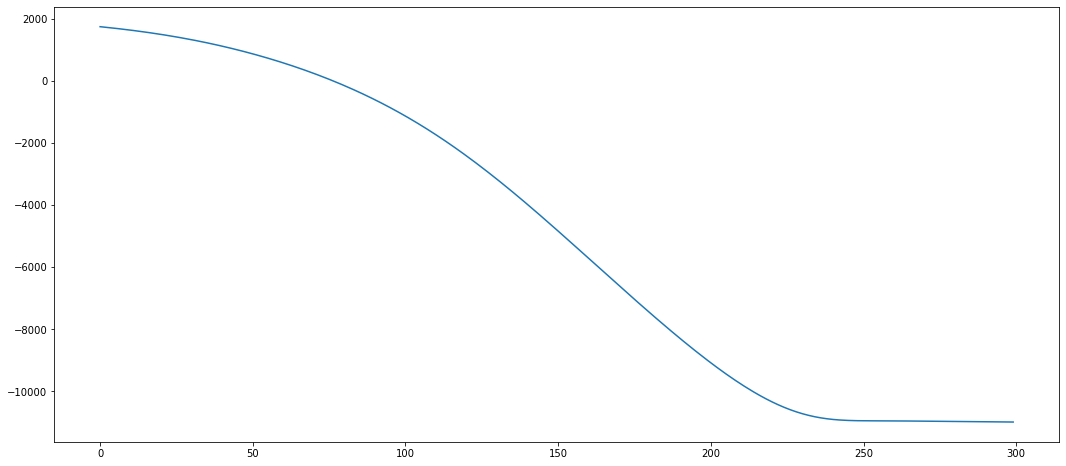

In [448]:
model.plot_loss()

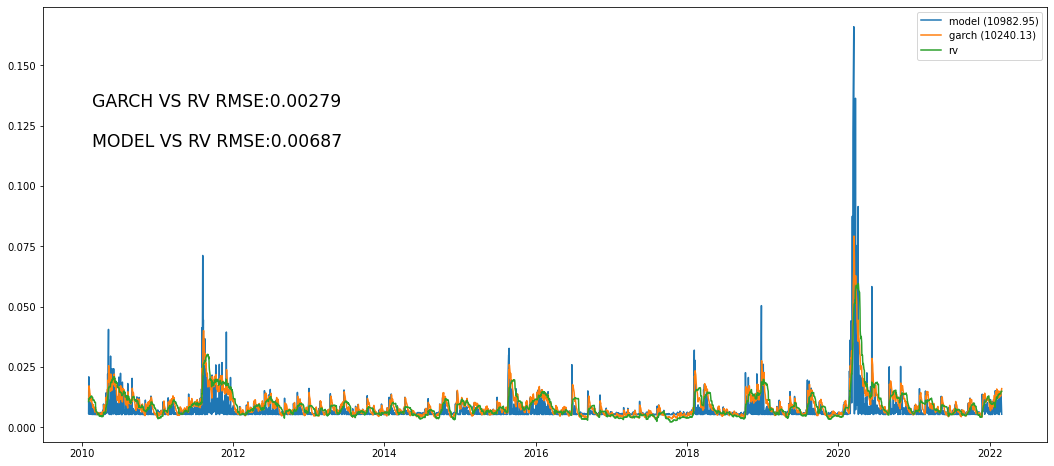

In [449]:
#plt.plot(rets.iloc[21:], label = 'returns')
plt.plot(rets.iloc[21:].index, model(data)**.5, label = 'model ({:7.2f})'.format(-model.loss_to_plot[-1]))
plt.plot(rets.iloc[21:].index, fit.conditional_volatility.iloc[21:],
         label = 'garch ({:7.2f})'.format(fit.loglikelihood))
plt.plot(rets.iloc[21:].index,tf_rv.numpy().ravel(), label = 'rv')
#take a look on what you plot on garch nll later
plt.plot()
plt.text(x = rets.iloc[21:].index[10], y = 0.8*max(model(data)**.5), s = 'GARCH VS RV RMSE:{:1.5f}'\
         .format(mse(tf_rv.numpy().ravel(),fit.conditional_volatility.iloc[21:]) **.5),
         fontsize = 'xx-large')
plt.text(x = rets.iloc[21:].index[10], y = .7*max(model(data)**.5), s = 'MODEL VS RV RMSE:{:1.5f}'\
         .format(mse(tf_rv.numpy().ravel(), model(data)**.5)**.5), fontsize = 'xx-large')
plt.legend()
plt.show()

In [339]:
garch = arch_model(rets, mean='Zero', vol='GARCH', p=1, q=1)
fit = garch.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -10240.131911482327
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10240.131898108337
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\Giorgio\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [332]:
fit.conditional_volatility

Date
2010-01-04    0.010119
2010-01-05    0.011424
2010-01-06    0.010272
2010-01-07    0.009201
2010-01-08    0.008416
                ...   
2022-02-22    0.013485
2022-02-23    0.012918
2022-02-24    0.014286
2022-02-25    0.014259
2022-02-28    0.016018
Name: cond_vol, Length: 3060, dtype: float64

In [12]:
fit.loglikelihood

10277.402279034482

In [35]:
nll2(tf.convert_to_tensor(fit.conditional_volatility, dtype = 'float32')[21:], tf_rets)

<tf.Tensor: shape=(), dtype=float32, numpy=-10211.92>

In [34]:
def nll2(sigma, r):
    sigma+=0
    T = sigma.shape[0]
    return .5*T*m.log(2*pi)+m.reduce_sum(m.log(sigma)+m.divide(r**2, 2*sigma**2))